In [3]:
import os
import numpy as np
import torch
import glob
import torch.nn as nn
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision
import pathlib
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import math

In [4]:
def set_device():
    device = "mps" if torch.backends.mps.is_available() else "cpu"
    return device
device=set_device()

In [5]:
batch_size = 64

In [6]:
path = "dataset_20_classes"
dataset = datasets.ImageFolder(root=path,transform = transforms.ToTensor())
data_loader = torch.utils.data.DataLoader(dataset = dataset,batch_size=batch_size,shuffle=False)

In [7]:
root=pathlib.Path(path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['.DS_Store', 'Apple_healthy', 'Apple_unhealthy', 'Cherry_healthy', 'Cherry_unhealthy', 'Grape_healthy', 'Grape_unhealthy', 'Mango_healthy', 'Mango_unhealthy', 'Peach_healthy', 'Peach_unhealthy', 'Pepperbell_healthy', 'Pepperbell_unhealthy', 'Pomegranate_healthy', 'Pomegranate_unhealthy', 'Potato_healthy', 'Potato_unhealthy', 'Strawberry_healthy', 'Strawberry_unhealthy', 'Tomato_healthy', 'Tomato_unhealthy']


In [8]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
#         print(images.shape)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

In [9]:
def transform(dataset):
    data_transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    data_loader=torch.utils.data.DataLoader(dataset=data_set,batch_size=32,shuffle=True)
    mean,std=get_mean_std(data_loader)
    data_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    return data_set

In [10]:
dataset = transform(path)

In [11]:
train_size = int(0.7 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset)-train_size-val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size,test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, drop_last=False, num_workers=0)
val_loader   = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=0)
print(str(train_size)+" "+str(val_size)+" "+str(test_size))

13803 1971 3945


In [12]:
model = models.mobilenet_v2(pretrained=False, num_classes=20)
model.to(device)

/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/bhanuprakash/miniforge3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [16]:
optimizer=torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.9)
criterion=nn.CrossEntropyLoss()
num_epochs=50
batch_size = batch_size
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)

In [17]:
train_count = len(train_dataset)
test_count = len(test_dataset)
val_count = len(val_dataset)

In [19]:
import time

In [22]:
n_epochs = 50
epoch_count = 0
Accuracies = [] 
valAccuracies = []
valLoss = []
trainLoss = []
total_steps = len(train_loader)
t1 = time.time()
validation_accuracy = 0

In [23]:
for epoch in range(n_epochs):
    print("Epoch: %d "%(epoch+1))
    model.train()
    running_loss=0.0
    running_correct=0.0
    val_loss=0.0
    total=0
    t1 = time.time()
    for i,data in enumerate(train_loader):
        images,labels=data
        images=images.to(device)
        labels=labels.to(device)
        total+=labels.size(0)
        optimizer.zero_grad()
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        loss=criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        running_correct+=(labels==predicted).sum().item()
        traning_accuracy=(running_correct/total)*100
    
    validation_accuracy=0
    model.eval()
    with torch.no_grad():
        val_correct=0
        val_total=0
        val_loss=0
        for data in val_loader:
            images,val_labels=data[0].to(device), data[1].to(device)
            images = images.to(device)
            val_labels = val_labels.to(device)
            outputs=model(images)
            loss_val=criterion(outputs,val_labels)
            val_loss+= loss_val.item()
            _,predicted=torch.max(outputs.data,1)
            val_correct+=(predicted == val_labels).sum().item()
            val_total+=val_labels.size(0)
        validation_accuracy = (val_correct / val_total) *100
    
    scheduler.step()
    epoch_loss=running_loss/len(train_loader)
    val_loss=val_loss/len(val_loader)
    epoch_accuracy=100.00* running_correct/total
    Accuracies.append(epoch_accuracy)
    valAccuracies.append(validation_accuracy)
    trainLoss.append(epoch_loss)
    valLoss.append(val_loss)
    print("######## epoch Finished in {} seconds ###########".format(time.time()\
                                                                    -t1))
    print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f, Validation Loss: %.3f, Validation Accuracy: %.3f"%(epoch_loss,epoch_accuracy,val_loss,validation_accuracy))
    
        

Epoch: 1 
######## epoch Finished in 147.98110795021057 seconds ###########
Training Data: Epoch Loss: 1.065, Epoch Accuracy: 65.160, Validation Loss: 0.909, Validation Accuracy: 70.472
Epoch: 2 
######## epoch Finished in 148.05103278160095 seconds ###########
Training Data: Epoch Loss: 0.836, Epoch Accuracy: 72.970, Validation Loss: 0.708, Validation Accuracy: 77.524
Epoch: 3 
######## epoch Finished in 146.15559601783752 seconds ###########
Training Data: Epoch Loss: 0.670, Epoch Accuracy: 78.679, Validation Loss: 0.604, Validation Accuracy: 79.706
Epoch: 4 
######## epoch Finished in 146.67982721328735 seconds ###########
Training Data: Epoch Loss: 0.528, Epoch Accuracy: 83.438, Validation Loss: 0.446, Validation Accuracy: 86.657
Epoch: 5 
######## epoch Finished in 147.00813794136047 seconds ###########
Training Data: Epoch Loss: 0.427, Epoch Accuracy: 86.814, Validation Loss: 0.371, Validation Accuracy: 88.686
Epoch: 6 
######## epoch Finished in 145.91365003585815 seconds ######

######## epoch Finished in 146.11613178253174 seconds ###########
Training Data: Epoch Loss: 0.053, Epoch Accuracy: 98.290, Validation Loss: 0.067, Validation Accuracy: 97.666
Epoch: 46 
######## epoch Finished in 146.30192303657532 seconds ###########
Training Data: Epoch Loss: 0.049, Epoch Accuracy: 98.493, Validation Loss: 0.051, Validation Accuracy: 98.427
Epoch: 47 
######## epoch Finished in 146.25640773773193 seconds ###########
Training Data: Epoch Loss: 0.045, Epoch Accuracy: 98.602, Validation Loss: 0.049, Validation Accuracy: 98.224
Epoch: 48 
######## epoch Finished in 145.98413276672363 seconds ###########
Training Data: Epoch Loss: 0.036, Epoch Accuracy: 98.957, Validation Loss: 0.045, Validation Accuracy: 98.427
Epoch: 49 
######## epoch Finished in 146.1990749835968 seconds ###########
Training Data: Epoch Loss: 0.034, Epoch Accuracy: 99.080, Validation Loss: 0.034, Validation Accuracy: 98.833
Epoch: 50 
######## epoch Finished in 145.96239614486694 seconds ###########


In [25]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total+=labels.size(0)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            predicted_correct += (predicted == labels).sum().item()
    epoch_accuracy = 100.0* predicted_correct/total
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

In [27]:
evaluate_model(model,test_loader)

Testing Data: Epoch Accuracy: 98.352


98.35234474017744

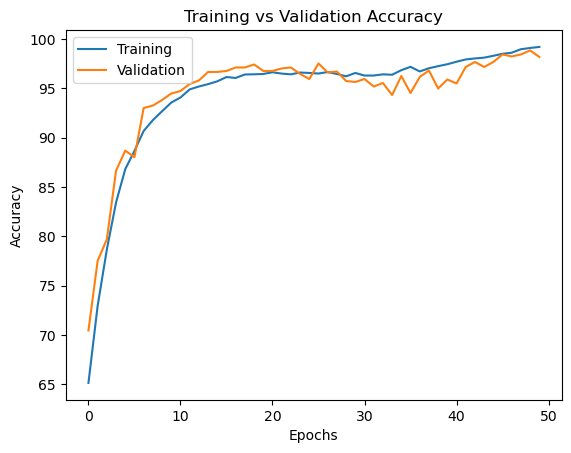

In [28]:
plt.plot(range(num_epochs),Accuracies,label="Training")
plt.plot(range(num_epochs),valAccuracies, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.show()

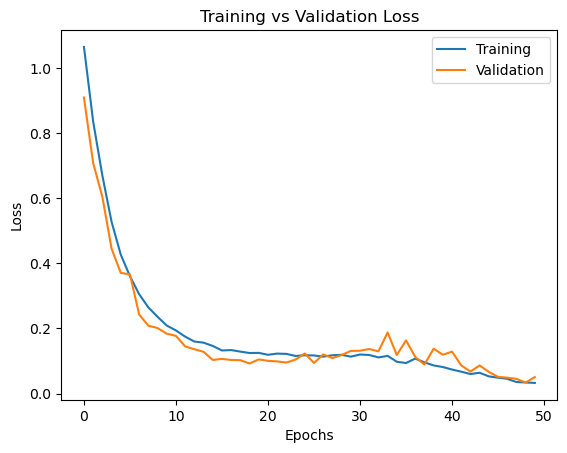

In [29]:
plt.plot(range(num_epochs),trainLoss,label="Training")
plt.plot(range(num_epochs),valLoss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [31]:
y_pred = []
y_true = []

for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) 
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

In [34]:
classes=classes[1:]

In [35]:
print(classes)

['Apple_healthy', 'Apple_unhealthy', 'Cherry_healthy', 'Cherry_unhealthy', 'Grape_healthy', 'Grape_unhealthy', 'Mango_healthy', 'Mango_unhealthy', 'Peach_healthy', 'Peach_unhealthy', 'Pepperbell_healthy', 'Pepperbell_unhealthy', 'Pomegranate_healthy', 'Pomegranate_unhealthy', 'Potato_healthy', 'Potato_unhealthy', 'Strawberry_healthy', 'Strawberry_unhealthy', 'Tomato_healthy', 'Tomato_unhealthy']


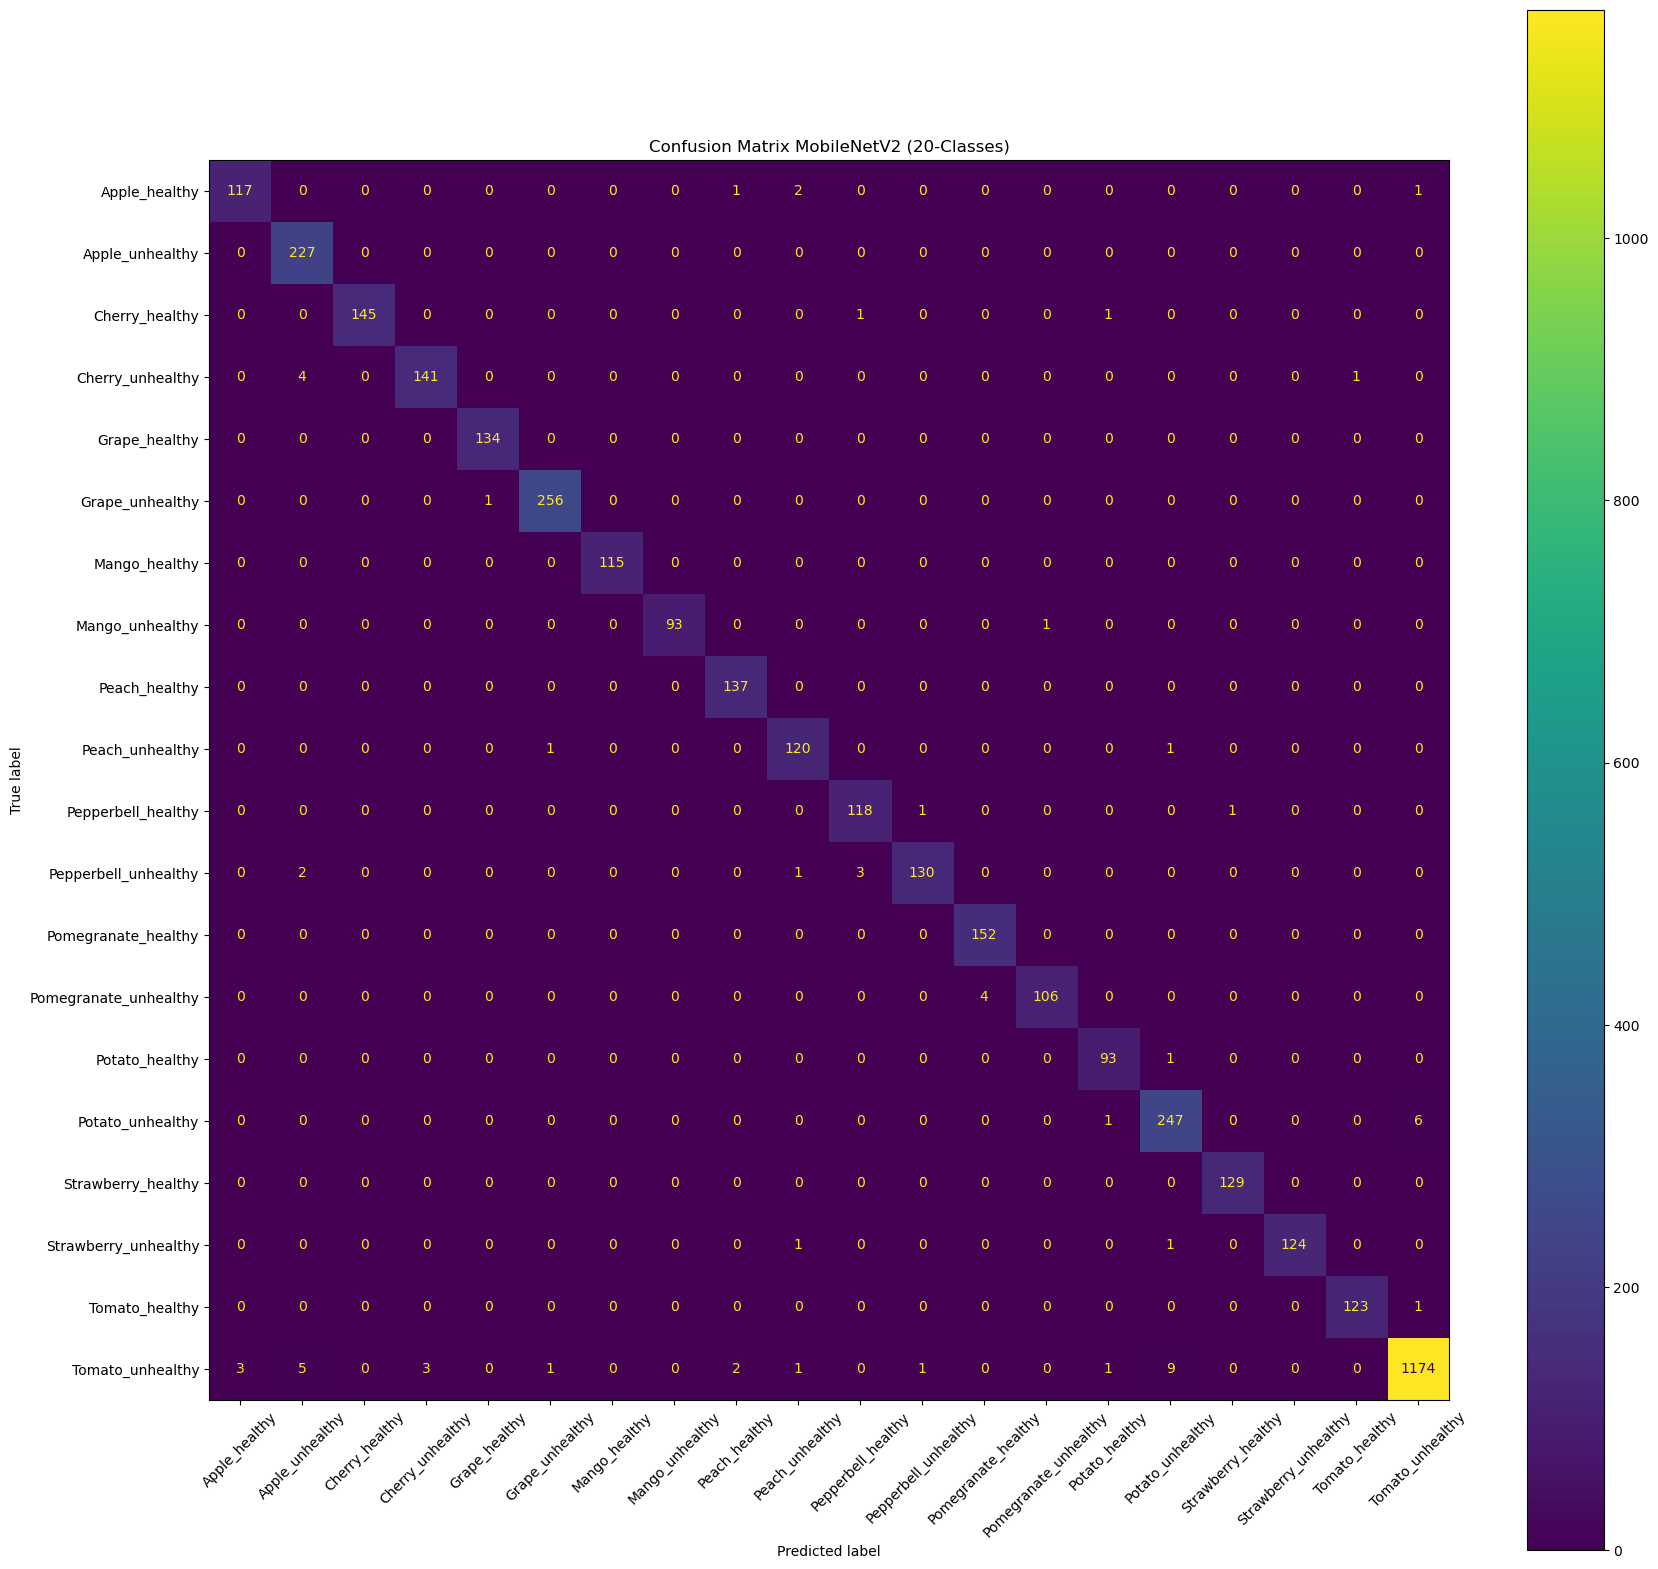

In [50]:
confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=classes)
fig,ax = plt.subplots()
fig.set_size_inches(20,20)
plt.title("Confusion Matrix MobileNetV2 (20-Classes)")
disp.plot(ax=ax,xticks_rotation=45)
plt.show()

In [51]:
print("Precision Macro:{:.2f}".format(precision_score(y_true, y_pred, average='macro')))
print("Precision Micro:{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
print("Recall Macro:{:.2f}".format(recall_score(y_true,y_pred,average='macro')))
print("Recall Micro:{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
print("F1-Score Macro:{:.2f}".format(f1_score(y_true,y_pred,average='macro')))
print("F1-Score Micro:{:.2f}".format(f1_score(y_true,y_pred,average='micro')))

Precision Macro:0.98
Precision Micro:0.98
Recall Macro:0.99
Recall Micro:0.98
F1-Score Macro:0.98
F1-Score Micro:0.98
